# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/assignment4/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/assignment4/" $datadir
os.chdir(datadir)
!pwd

/content/drive/My Drive/assignment4


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


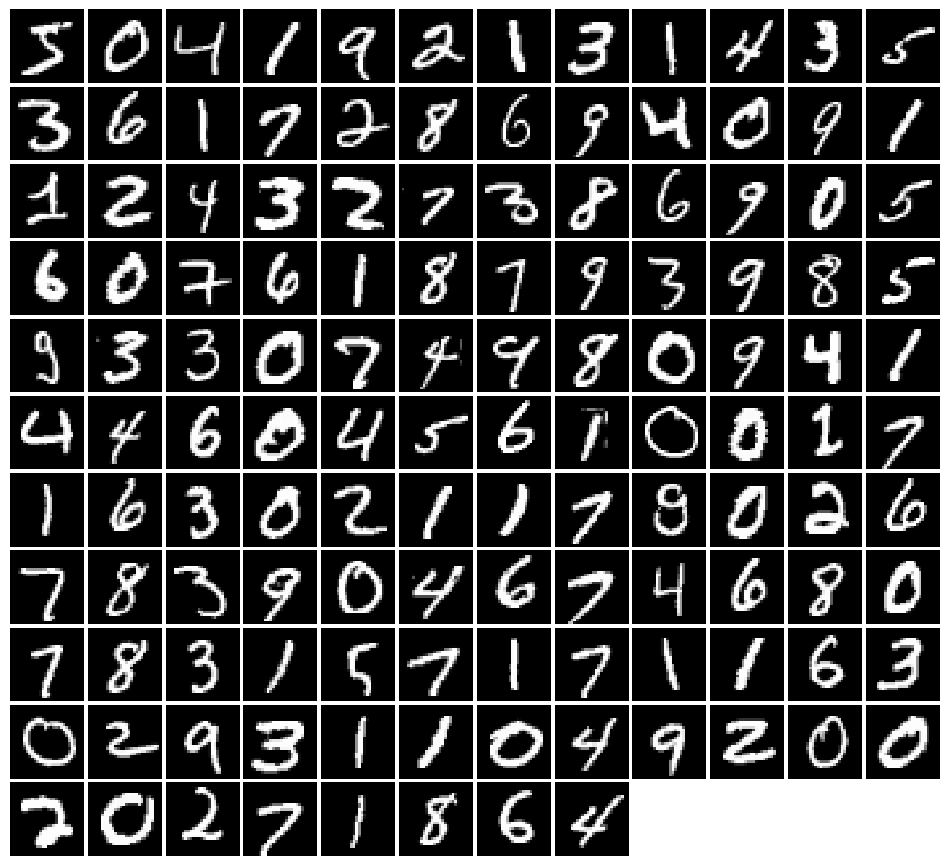

In [6]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        N, *other = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [8]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [9]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        Flatten(),
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.412, G:0.6998


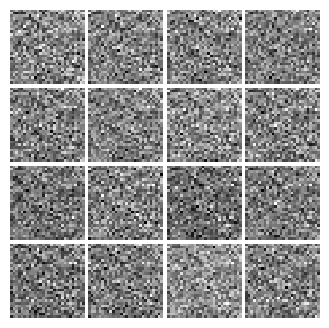


Iter: 250, D: 1.018, G:1.01


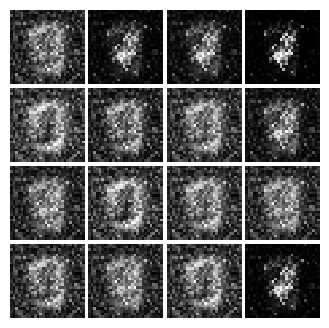


EPOCH:  2
Iter: 500, D: 0.68, G:1.576


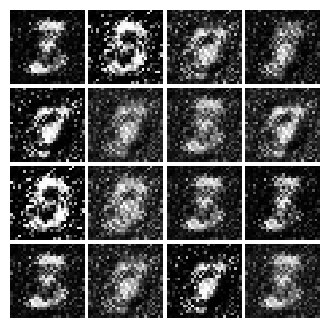


Iter: 750, D: 1.05, G:1.345


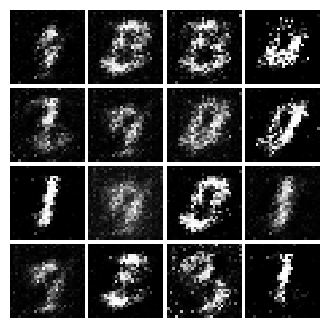


EPOCH:  3
Iter: 1000, D: 0.8955, G:1.324


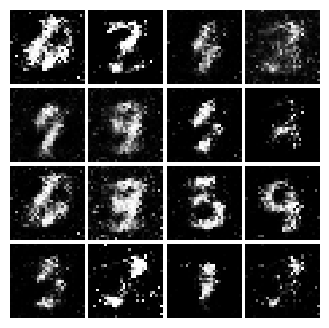


Iter: 1250, D: 1.23, G:1.465


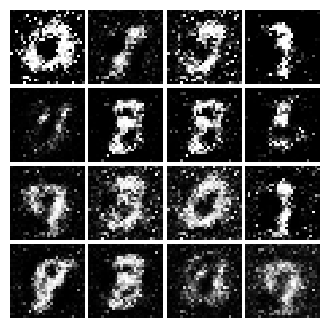


EPOCH:  4
Iter: 1500, D: 1.082, G:1.207


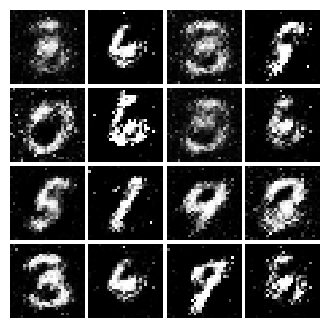


Iter: 1750, D: 1.12, G:1.16


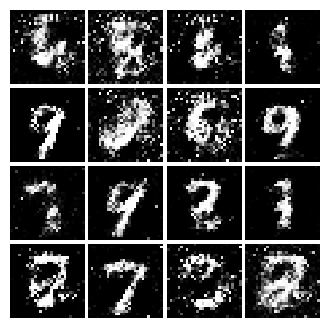


EPOCH:  5
Iter: 2000, D: 1.339, G:0.8671


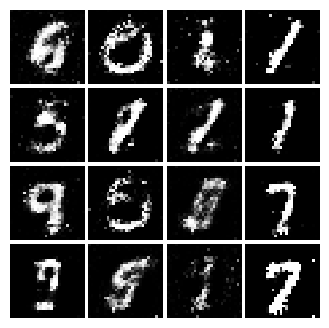


Iter: 2250, D: 1.289, G:0.7807


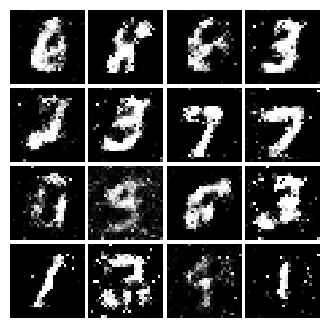


EPOCH:  6
Iter: 2500, D: 1.277, G:0.8925


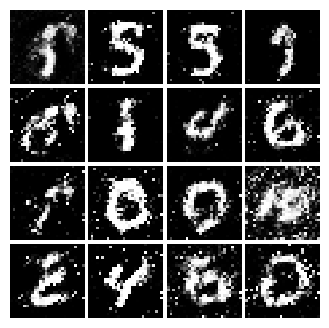


Iter: 2750, D: 1.458, G:0.9385


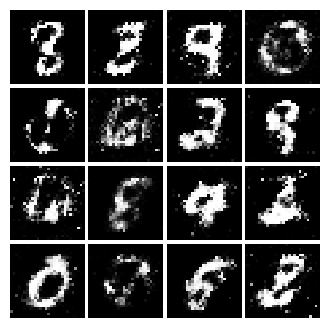


EPOCH:  7
Iter: 3000, D: 1.226, G:0.8718


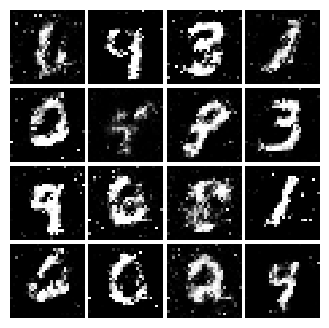


Iter: 3250, D: 1.214, G:0.8675


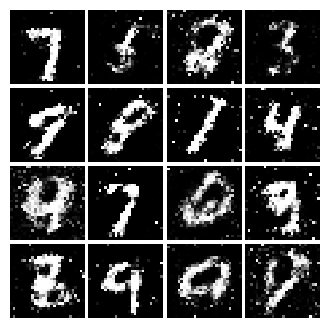


EPOCH:  8
Iter: 3500, D: 1.358, G:0.8001


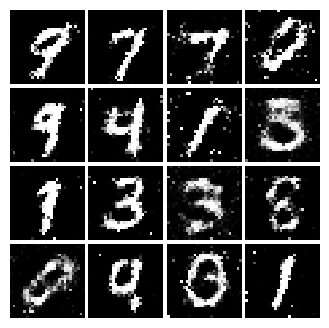


EPOCH:  9
Iter: 3750, D: 1.26, G:0.8652


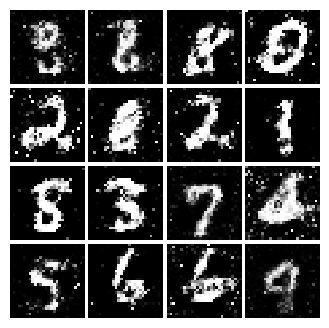


Iter: 4000, D: 1.295, G:0.8173


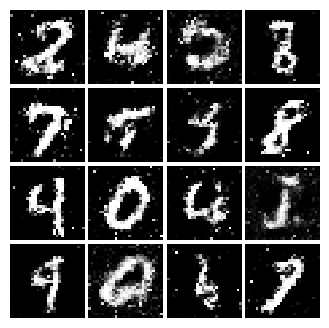


EPOCH:  10
Iter: 4250, D: 1.299, G:0.9004


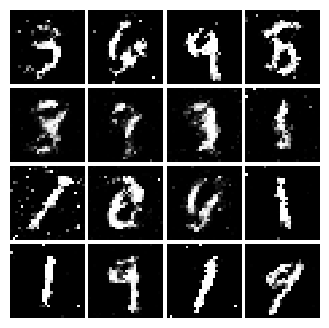


Iter: 4500, D: 1.322, G:0.888


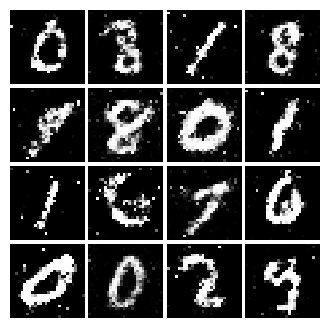

In [ ]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5374, G:0.539


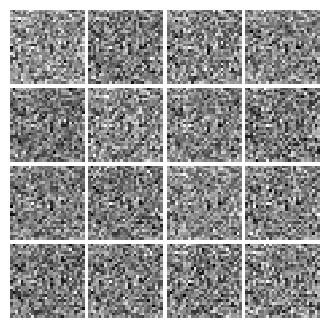


Iter: 250, D: 0.1622, G:0.3243


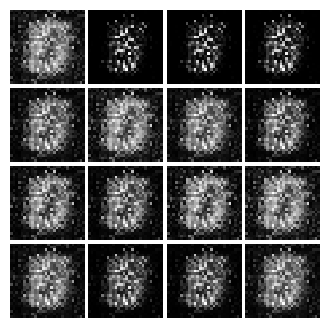


EPOCH:  2
Iter: 500, D: 0.06747, G:0.3905


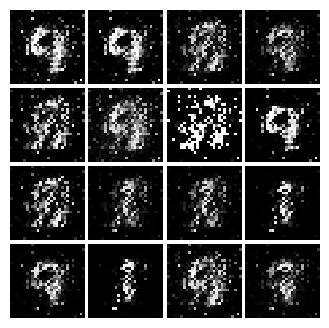


Iter: 750, D: 0.2278, G:0.2124


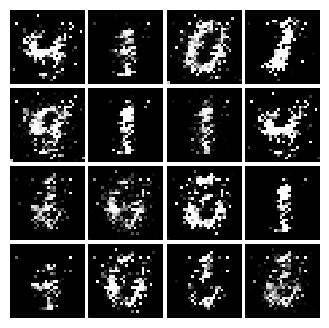


EPOCH:  3
Iter: 1000, D: 0.1453, G:0.2535


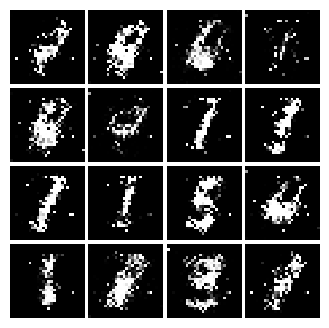


Iter: 1250, D: 0.1939, G:0.3256


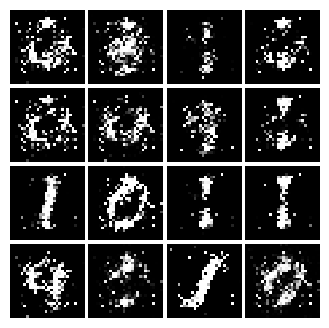


EPOCH:  4
Iter: 1500, D: 0.1726, G:0.2295


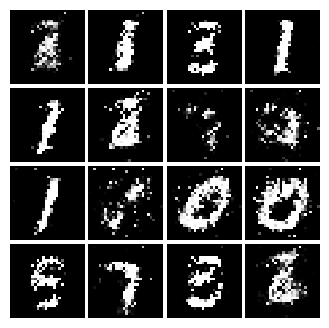


Iter: 1750, D: 0.2086, G:0.1711


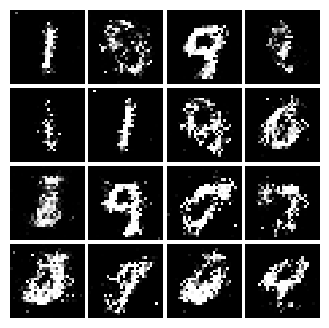


EPOCH:  5
Iter: 2000, D: 0.2208, G:0.1965


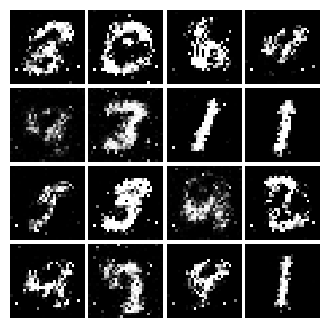


Iter: 2250, D: 0.1984, G:0.1857


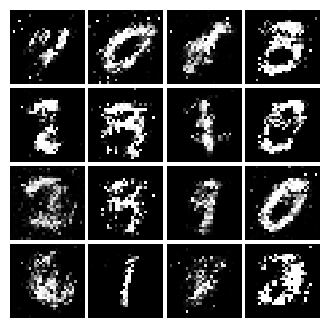


EPOCH:  6
Iter: 2500, D: 0.2226, G:0.1617


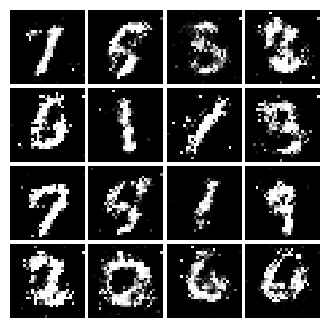


Iter: 2750, D: 0.2318, G:0.1625


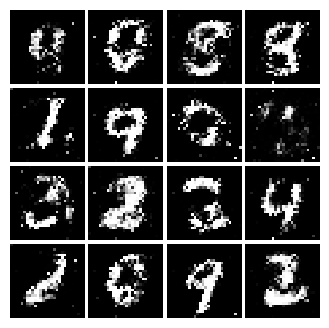


EPOCH:  7
Iter: 3000, D: 0.2278, G:0.1402


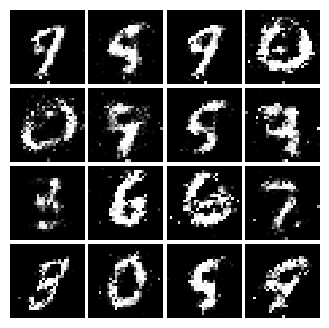


Iter: 3250, D: 0.2172, G:0.1758


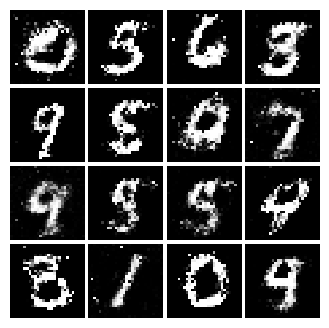


EPOCH:  8
Iter: 3500, D: 0.2651, G:0.1764


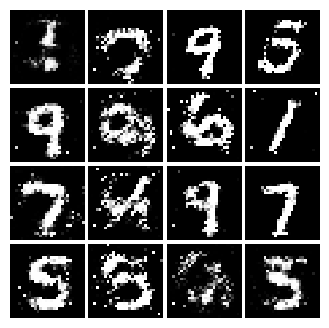


EPOCH:  9
Iter: 3750, D: 0.2077, G:0.1806


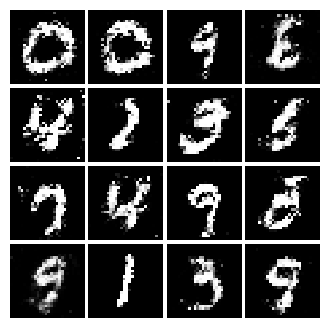


Iter: 4000, D: 0.2311, G:0.1563


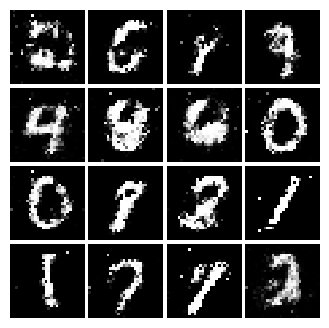


EPOCH:  10
Iter: 4250, D: 0.2298, G:0.1683


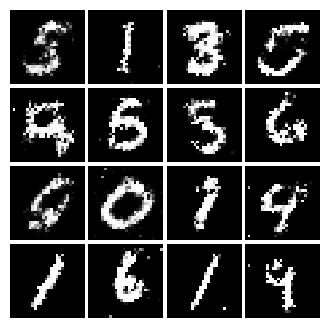


Iter: 4500, D: 0.2217, G:0.1576


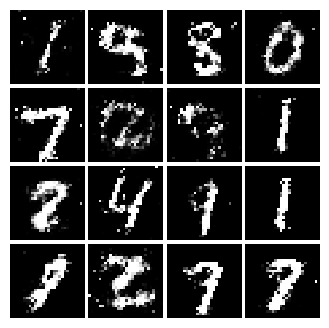

In [10]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)